# Imports and Pytorch Settings

In [1]:
# imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
from collections import defaultdict
from scipy.integrate import solve_ivp
from mpl_toolkits import mplot3d

In [2]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

# Check Library Version Info and GPU Availability

In [3]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Python VERSION:', sys.version)
  print('pyTorch VERSION:', torch.__version__)
  print('Active CUDA Device: GPU', torch.cuda.current_device())
  print('Available devices: ', torch.cuda.device_count())
  print('Current CUDA device: ', torch.cuda.current_device())
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()

Python VERSION: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
pyTorch VERSION: 2.0.1+cu118
Active CUDA Device: GPU 0
Available devices:  1
Current CUDA device:  0
Mon Jun 12 18:15:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+

# Compute Loss Function

In [4]:
# calculate gradient with respect to any x and use this to form loss
def compute_gradient(u, x, num_u_vectors):
    
    # compute gradient of outputs with respect to inputs 
    derivs_list = []
    for i in range(num_u_vectors):
        # individually compute du/dx for each u and combine them all together afterwards
        du_dx = torch.autograd.grad(u[:, i, :], x, grad_outputs=torch.ones_like(u[:, i, :]), create_graph=True)[0]
        derivs_list.append(du_dx)

    deriv_to_x = torch.stack(derivs_list, dim=1)
    
    return deriv_to_x

# build the loss function
def loss(x, A_list, v_list, force, G_list, model):
    
    # dictionary to store loss results for plotting
    loss_dict = {} 
    # current loss
    L = 0

    # create the trial solution
    model_result = lambda x: model(x)[0]
    u_results = model_result(x)
   
    # determine the number of u vectors
    num_u_vectors = u_results['head 1'].shape[1]
    
    # loss will be the sum of the terms from the "multi-head" model, hence we iterate over each head's outputs
    for i, head_i in enumerate(u_results.keys()):
        
        # extract the u for the current "head", corresponding to one of the initial conditions
        u = u_results[head_i].unsqueeze(dim=-1)

        # compute matrix of partial derivatives
        D_u = compute_gradient(u, x, num_u_vectors) 

        # compute D_U * G.T
        D_u_times_G_T = torch.matmul(D_u, G_list[i].T)

        # compute (D_U * G.T) x I where x is the Hadamard product
        identity_mat = torch.eye(num_u_vectors, device=dev)
        D_u_times_G_t_x_I = torch.mul(D_u_times_G_T, identity_mat)
      
        # compute ((D_U * G.T) x I) * [1, 1....]
        ones_vec = torch.ones(num_u_vectors, device=dev).unsqueeze(dim=-1)
        D_u_times_G_t_x_I_times_ones = torch.matmul(D_u_times_G_t_x_I, ones_vec)
        
        # compute A * u 
        A_times_u = torch.matmul(A_list[i], u)

        # compute the L_t term 
        L_t_term = D_u_times_G_t_x_I_times_ones + A_times_u - torch.stack([force] * len(x))
        L_t = torch.matmul(L_t_term.mT, L_t_term)                                 

        # extract u_0 from the model (BOUNDARY CONDITION DEPENDENT)
        x_0 = torch.cat([x[:, 0:1], torch.zeros(len(x), 1, device=dev)], dim=1)
        # x_0 = torch.cat([x[:, 0:1], x[:, 0:1]], dim=1)
        u_0 = model_result(x_0)[head_i]

        # compute the L_0_1 term (using the boundary condition)
        boundary_funct = v_list[i]
  
        L_0_1_term = (u_0 - boundary_funct(x)).reshape(len(x), -1, 1)  
        L_0_1 = torch.matmul(L_0_1_term.mT, L_0_1_term) 

        # compute the overall loss 
        L += (torch.mean(L_t) + torch.mean(L_0_1))

    loss_dict['L_D'] = L / len(A_list)
    loss_dict['L_total'] = L / len(A_list)

    return loss_dict

# Build Network

In [5]:
# class to build the network 
class BuildNetwork(nn.Module):
    def __init__(self, input_size, h_sizes, output_size, n_heads):
        super(BuildNetwork, self).__init__()
        # store the number of "heads" to use in the model
        self.n_heads = n_heads
        
        # build the layers to use for the forward pass
        self.l1 = nn.Linear(input_size, h_sizes[0])
        self.l2 = nn.Linear(h_sizes[0], h_sizes[1])
        self.l3 = nn.Linear(h_sizes[1], h_sizes[2]) 
        self.l4 = nn.Linear(h_sizes[2], h_sizes[3])
        self.l5 = nn.Linear(h_sizes[3], h_sizes[4])
        
        # create the necessary activation functions
        self.tanh = nn.Tanh()
        self.silu = nn.SiLU()
        self.softsign = nn.Softsign()
        self.softplus = nn.Softplus()
  
        # build n_heads output layers, each corresponding to different conditions during training
        self.multi_head_output = nn.ModuleList([nn.Linear(h_sizes[4], output_size)])
        self.multi_head_output.extend([nn.Linear(h_sizes[4], output_size) for i in range(n_heads-1)])

    def forward(self, x):
        # dictionary to store the output for each "head" in the model
        u_results = {}
        
        # all "heads" have the same pass through the hidden layers
        result = self.l1(x)
        result = self.silu(result)
        result = self.l2(result)
        result = self.silu(result)
        result = self.l3(result) 
        result = self.silu(result) 
        result = self.l4(result)
        result = self.silu(result)
        result = self.l5(result)
        
        # store h to return
        h = self.silu(result)

        # apply the corresponding output layer to each "head"
        for i in range(self.n_heads):
            result_i = self.multi_head_output[i](h)
            u_results[f"head {i + 1}"] = result_i
                         
        return u_results, h

# Train Model

In [6]:
# train and evaluate the model
def run_model(iterations, x_range, num_inputs, A_list, v_list, force, G_list, 
              hid_lay, num_equations, num_heads, true_functs, head_to_track, batch_size):
        
    assert num_equations > 0, 'num_equations must be >= 1'
    assert len(v_list) == num_heads, 'num_heads must equal the length of v_list'
    assert len(A_list) == num_heads, 'num_heads must equal the length of A_list'
    assert len(G_list) == num_heads, 'num_heads must equal the length of G_list'
    assert len(A_list[0]) == num_equations, 'num_equations does not match equation set-up'
    assert hid_lay[-1] % num_equations == 0, 'last hidden layer does not evenly divide num_equations for transfer learning'
    
    # build the neural net model
    model = BuildNetwork(num_inputs, hid_lay, num_equations, num_heads).to(dev)   

    # current best loss
    best_loss = float('inf')

    # set-up the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # extract the min and max range of values to sample
    min_x, max_x = x_range
    
    # index of the head being tracked for MSE
    head_idx = int(head_to_track.split()[-1]) - 1
    
    # create a random number generator for loss computation
    rng = np.random.default_rng()
    
    # store loss and mse values
    loss_history = defaultdict(list)
    MSEs = []
    
    start_time = time.time()
    
    # training loop
    for i in range(iterations):
        
        if i % 1000 == 0:
            print(f"Running Iteration {i + 1}")
        
        # every batch, randomly sample inputs from min and max range
        data = torch.arange(min_x, max_x, 0.0001, requires_grad=True, device=dev)
    
        # generate x1 and x2 separately to create 2D PDE input
        x1_jitter = torch.tensor(np.random.normal(0, 0.1, size=batch_size), dtype=torch.float32, device=dev)
        x1 = data[rng.choice(range(0, len(data)), size=batch_size, replace=False)] + x1_jitter
        x1 = x1.reshape(-1, 1)
        x2_jitter = torch.tensor(np.random.normal(0, 0.1, size=batch_size), dtype=torch.float32, device=dev)
        x2 = data[rng.choice(range(0, len(data)), size=batch_size, replace=False)] + x2_jitter
        x2 = x2.reshape(-1, 1)
        x = torch.cat([x1, x2], dim=1)

        # forward: compute loss
        curr_loss = loss(x, A_list, v_list, force, G_list, model)

        # save the current best model 
        if (curr_loss['L_total'].detach().item() < best_loss):
            best_loss = curr_loss['L_total'].detach().item()
            torch.save(model.state_dict(), "state_dict_model.pt")
                
        # store individual loss terms for plotting
        loss_history['LD_losses'].append(curr_loss['L_D'].detach().item())
        loss_history['Ltotal_losses'].append(curr_loss['L_total'].detach().item())

        # backward: backpropagation
        curr_loss['L_total'].backward()
      
        # update weights and reset the gradients
        optimizer.step() 
        optimizer.zero_grad() 
           
        # compute the mse for the head that is being monitored ('head_to_track')
        with torch.no_grad():
            current_mse = 0
            for j in range(num_equations):
                network_sol_j = model(x)[0][head_to_track][:, j].cpu().unsqueeze(dim=1).numpy()
                true_sol_j = true_functs(x.cpu(), A_list[head_idx].cpu(), v_list[head_idx], 
                                         G_list[head_idx].cpu(), force.cpu())[:, j] 
                true_sol_j = np.expand_dims(true_sol_j, axis=1)
                current_mse += np.mean((true_sol_j - network_sol_j) ** 2)
            MSEs.append(current_mse)
               
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Model Training Complete in{total_time: .3f} seconds")

    # retrieve the best model and set to evaluation mode
    best_model = BuildNetwork(num_inputs, hid_lay, num_equations, num_heads).to(dev) 
    best_model.load_state_dict(torch.load("state_dict_model.pt"))
    best_model.eval()

    return loss_history, best_model, total_time, MSEs

# Plot Solution, Loss, and MSE Information

In [7]:
# function to plot the neural network vs exact solution
def plot_solution(x_range, true_functs, trained_model, v_list, A_list, force, G_list, axis, head_to_track):
    
    # function to extract the model results
    model_result = lambda x: trained_model(x)[0]
    
    # x values to predict on
    min_x, max_x = x_range
    xx1 = np.linspace(min_x, max_x, 200)[:, None]
    xx2 = np.linspace(min_x, max_x, 200)[:, None]
    xx = torch.tensor(np.concatenate((xx1, xx2), axis=1), 
                                  dtype=torch.float32, device=dev)

    # find the model results
    u = model_result(xx)[head_to_track] 

    # determine the number of curves to plot
    num_curves = u.shape[1]
    # store the true solutions and network solutions
    yys, yts = [], []

    # save the network solutions in a list for plotting 
    with torch.no_grad():
        head_idx = int(head_to_track.split()[-1]) - 1
        for i in range(num_curves):
            yys.append(u[:, i].cpu().numpy())
            yts.append(true_functs(xx.cpu(), A_list[head_idx].cpu(), 
                                   v_list[head_idx], G_list[head_idx].cpu(), force.cpu()))
      
    # plot the network solutions
    for i in range(num_curves):
      axis.plot3D(xx1.squeeze(), xx2.squeeze(), yys[i], 'x', markersize=8,
                  label=f'Network Solution $u_{{{i+1}}}(x_1, x_2)$ ({head_to_track})', 
                  linewidth=3.5)

    # plot the true solutions
    for i in range(num_curves):
      axis.plot3D(xx[:, 0].cpu().numpy(), xx[:, 1].cpu().numpy(), 
                  yts[i][:, i].cpu().squeeze(), 
                  label=f'Analytical Solution $u_{{{i+1}}}(x_1, x_2)$', 
                  linewidth=2.5)
    
    axis.set_title("$u(x_1, x_2)$ for Network and Analytical Solutions",  fontsize=20)
    axis.set_xlabel('$x_1$', fontsize=16)
    axis.set_ylabel('$x_2$', fontsize=16)
    axis.set_zlabel('$u(x_1, x_2)$', fontsize=16)
    axis.set_xticklabels(axis.get_xticklabels(), fontsize=11)
    axis.set_yticklabels(axis.get_yticklabels(), fontsize=11)
    axis.set_zticklabels(axis.get_zticklabels(), fontsize=11)
    axis.legend(loc='upper left', fontsize=14)
    
# function to plot the overall loss of the network solution
def plot_total_loss(iterations, train_losses, axis, loss_label):
    axis.plot(range(iterations), train_losses, label=loss_label)
    axis.set_yscale("log")
    axis.set_title("Total Loss vs Iterations", fontsize=20)
    axis.set_xlabel('Iterations', fontsize=16)
    axis.set_ylabel('Loss', fontsize=16)
    axis.set_xticklabels(axis.get_xticklabels(), fontsize=12)
    axis.set_yticklabels(axis.get_yticklabels(), fontsize=12)
    axis.grid()
    axis.legend(loc='best', fontsize=16)
    
# function to plot the MSEs
def plot_mse(iterations, mses, axis, head_to_track):
    axis.plot(range(iterations), mses, label=f'MSE ({head_to_track})')
    axis.set_yscale("log")
    axis.set_title("MSE vs Iterations", fontsize=20)
    axis.set_xlabel('Iterations', fontsize=16)
    axis.set_ylabel('MSE', fontsize=16)
    axis.set_xticklabels(axis.get_xticklabels(), fontsize=12)
    axis.set_yticklabels(axis.get_yticklabels(), fontsize=12)
    axis.grid()
    axis.legend(loc='best', fontsize=16)
    
# wrapper function to plot the solution and the overall loss & MSE of the network solution
def plot_loss_mse_and_solution(x_range, true_functs, iterations, trained_model, v_list, 
                               A_list, force, G_list, train_losses, loss_label, mses, head_to_track):
    
    fig = plt.figure(figsize=(24, 8))
    
    ax_0 = fig.add_subplot(1, 3, 1)
    plot_total_loss(iterations=iterations, train_losses=train_losses, 
                    axis=ax_0, loss_label=loss_label)
    
    ax_1 = fig.add_subplot(1, 3, 2, projection='3d')
    plot_solution(x_range=x_range, true_functs=true_functs, 
                  trained_model=trained_model, v_list=v_list,
                  A_list=A_list, force=force, G_list=G_list, 
                  axis=ax_1, head_to_track=head_to_track)
    
    ax_2 = fig.add_subplot(1, 3, 3)
    plot_mse(iterations=iterations, mses=mses, axis=ax_2, 
             head_to_track=head_to_track)
    
    plt.show()


# wrapper function to plot all heads and the overall loss & MSE of the network solution
def plot_loss_mse_and_all_solution(x_range, true_functs, iterations, trained_model, v_list, 
                               A_list, force, G_list, train_losses, loss_label, mses):
    
  fig = plt.figure(tight_layout=True, figsize=(24, 16))
    
  ax_0 = fig.add_subplot(2, 3, 1)
  plot_total_loss(iterations=iterations, train_losses=train_losses, 
                    axis=ax_0, loss_label=loss_label)
    
  ax_1 = fig.add_subplot(2, 3, 2)
  plot_mse(iterations=iterations, mses=mses, axis=ax_1, 
             head_to_track='head 1')
    
  ax_2 = fig.add_subplot(2, 3, 3, projection='3d')
  plot_solution(x_range=x_range, true_functs=true_functs, 
                trained_model=trained_model, v_list=v_list,
                A_list=A_list, force=force, G_list=G_list, 
                axis=ax_2, head_to_track='head 1')
  
  ax_3 = fig.add_subplot(2, 3, 4, projection='3d')
  plot_solution(x_range=x_range, true_functs=true_functs, 
                trained_model=trained_model, v_list=v_list,
                A_list=A_list, force=force, G_list=G_list, 
                axis=ax_3, head_to_track='head 2')

  ax_4 = fig.add_subplot(2, 3, 5, projection='3d')   
  plot_solution(x_range=x_range, true_functs=true_functs, 
                trained_model=trained_model, v_list=v_list,
                A_list=A_list, force=force, G_list=G_list, 
                axis=ax_4, head_to_track='head 3')

  ax_5 = fig.add_subplot(2, 3, 6, projection='3d')     
  plot_solution(x_range=x_range, true_functs=true_functs, 
                trained_model=trained_model, v_list=v_list,
                A_list=A_list, force=force, G_list=G_list, 
                axis=ax_5, head_to_track='head 4')
      
  plt.show()

# Find Output Layer Weights with Transfer Learning

In [8]:
# function to compute the H and S components 
def compute_H_and_S(min_x, max_x, G, trained_model, num_equations, hid_lay):

  start_time = time.time()

  # generate a set of inputs to evaluate with
  eval_size = 512
  rng = np.random.default_rng()
  data = torch.arange(min_x, max_x, 0.001, requires_grad=True, device=dev)
  x1 = data[rng.choice(range(0, len(data)), size=eval_size, replace=False)]
  x1, _ = x1.reshape(-1, 1).sort(dim=0)
  x2 = data[rng.choice(range(0, len(data)), size=eval_size, replace=False)]
  x2, _ = x2.reshape(-1, 1).sort(dim=0)
  x = torch.cat([x1, x2], dim=1)

  # forward pass with x to extract H 
  _, H = trained_model(x)
  H = H.reshape(-1, num_equations, hid_lay[-1] // num_equations)

  # build S matrix 
  _, H_orig = trained_model(x)
  dH_dx = [torch.autograd.grad(H_orig[:, i], x, grad_outputs=torch.ones_like(H_orig[:, i]), create_graph=True)[0] for i in range(H_orig.shape[1])]
  dH_dx = torch.hstack(dH_dx)
  H_x1 = dH_dx[:, range(0, eval_size, 2)]
  H_x1 = H_x1.reshape(-1, num_equations, hid_lay[-1] // num_equations)
  H_x1 = torch.cat((torch.zeros(len(x), num_equations, 1, device=dev), H_x1), 2)
  H_x2 = dH_dx[:, range(1, eval_size, 2)]
  H_x2 = H_x2.reshape(-1, num_equations, hid_lay[-1] // num_equations)
  H_x2 = torch.cat((torch.zeros(len(x), num_equations, 1, device=dev), H_x2), 2)

  # multiply the "H" components by the appropriate "G" coefficients
  if num_equations == 1: 
    S = G[0][0] * H_x1 + G[0][1] * H_x2
  elif num_equations == 2: 
    S = torch.mul(G[:, 0:1], H_x1) + torch.mul(G[:, 1:2], H_x2)
  
  # concatenate 1s onto H to account for intercept
  H = torch.cat((torch.ones(len(x), num_equations, 1, device=dev), H), 2)

  # forward pass with (x, 0) to extract H_0 (BOUNDARY CONDITION DEPENDENT)
  x_0 = torch.cat([x[:, 0:1], torch.zeros(len(x), 1, device=dev)], dim=1)
  # x_0 = torch.cat([x[:, 0:1], x[:, 0:1]], dim=1)
  _, H_0 = trained_model(x_0)

  # reshape H_0 to batch_size X num_equations X d // num_equations
  H_0 = H_0.reshape(-1, num_equations, hid_lay[-1] // num_equations)
  H_0 = torch.cat((torch.ones(len(x), num_equations, 1, device=dev), H_0), 2)

  end_time = time.time()
  total_time = end_time - start_time
  print(f"Time to compute H and dH_dt: {total_time: .3f} seconds")

  return H, S, H_0, x, x_0

In [9]:
# function to analytically compute W_0 (transfer learned weights)
def analytically_compute_weights(H, H_0, S, x, x_0, v, A, force):
    
    # compute S.T * S
    S_T_times_S = torch.matmul(S.mT, S)

    # compute S.T * A * H 
    S_T_times_A_H = torch.matmul(torch.matmul(S.mT, A), H)

    # compute H.T * A.T * S
    H_T_times_A_T_times_S = torch.matmul(torch.matmul(H.mT, A.T), S)

    # compute H.T * A.T * A * H 
    H_T_times_A_T_times_A_times_H = torch.matmul(torch.matmul(torch.matmul(H.mT, A.T), A), H)

    # compute H_0.T * H_0
    H_0_T_times_H_0 = torch.matmul(H_0.mT, H_0)

    # compute the the M matrix 
    M_sum_terms = S_T_times_S + S_T_times_A_H + H_T_times_A_T_times_S + H_T_times_A_T_times_A_times_H + H_0_T_times_H_0
    M = M_sum_terms.mean(axis=0)

    # invert the "M" matrix 
    M_inv = torch.linalg.pinv(M)
    print("M condition number: ", torch.linalg.cond(M))

    # compute S.T * force
    S_T_times_f = torch.matmul(S.mT, force)

    # compute H * A.T * force
    H_T_times_A_T_f = torch.matmul(torch.matmul(H.mT, A.T), force)

    # sum the force-contributing terms
    force_terms = S_T_times_f + H_T_times_A_T_f
    force_terms = force_terms.mean(axis=0)

    # add the force-contributing terms to H_0 * v
    v_eval = v(x_0).reshape(-1, H.shape[1], 1)

    H_0_T_times_u_0 = torch.matmul(H_0.mT, v_eval).mean(axis=0)
    rhs_terms = force_terms + H_0_T_times_u_0

    # compute the output weights by W_out = M ^-1 * (force_terms + H_0 * v)
    W_out = torch.matmul(M_inv, rhs_terms)

    return M_inv, W_out, force_terms

# Plot Transfer Learned and Analytical Solutions

In [10]:
# function to plot the transfer learned and analytical solutions on the same graph
def plot_transfer_learned_and_analytical_3D(H, W_out, x, v, A, G, force, num_equations, true_funct):

  fig = plt.figure(figsize=(20, 8))
  ax0 = fig.add_subplot(1, 2, 1, projection='3d')

  # clip the values to the range of interest
  indices = torch.where(torch.where(x <= 1, True, False).sum(axis=1) > 0, True, False)
  H = H[indices, :, :]
  x = x[indices, :]
  
  # compute the transfer learned solution
  u_transfer = torch.matmul(H, W_out)

  # plot the transfer learned solutions
  for i in range(num_equations):
      ax0.plot3D(x[:, 0].detach().cpu().numpy(), x[:, 1].detach().cpu().numpy(),
                  u_transfer[:, i, :].detach().cpu().numpy().squeeze(), 'x', 
                  markersize=8, label=f'Transfer Learned $U_{{{i+1}}}$', linewidth=3.5);

  # plot the true solutions 
  for i in range(num_equations):
    ax0.plot3D(x[:, 0].detach().cpu().numpy(), x[:, 1].detach().cpu().numpy(), 
                    true_funct(x.cpu(), A.detach().cpu(), v, G.cpu(), 
                               force.cpu()).detach().numpy()[:, i],
                    label= f'Analytical $U_{{{i+1}}}$', linewidth=2.5);
      
  ax0.set_title("$u(x_1, x_2)$ for Transfer Learned and Analytical Solutions", fontsize=20)
  ax0.set_xlabel('$x_1$', fontsize=16)
  ax0.set_ylabel('$x_2$', fontsize=16)
  ax0.set_zlabel('$u(x_1, x_2)$', fontsize=16)
  ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=14)
  ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=14)
  ax0.set_zticklabels(ax0.get_zticklabels(), fontsize=14)
  ax0.legend(loc='upper left', fontsize=16)

  ax1 = fig.add_subplot(1, 2, 2)

  # plot the transfer learned solutions
  for i in range(num_equations):

    predicted_vals =  u_transfer[:, i, :].detach().cpu().numpy().squeeze()
    true_vals =  true_funct(x.cpu(), A.detach().cpu(), v, G.cpu(), 
                               force.cpu()).detach().numpy()[:, i]
      
    residuals = (predicted_vals - true_vals) ** 2
    ax1.plot(x[:, 0].detach().cpu().numpy(), residuals, label=f'Residual $U_{{{i+1}}}$')


  # plot the true solutions
  ax1.set_title("Plot of Residuals vs Network Input $x_1$", fontsize=20)
  ax1.set_xlabel("Network Input $x_1$",fontsize=16)
  ax1.set_ylabel('Residual Value', fontsize=16)
  ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=14)
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=14)
  ax1.set_yscale('log')
  ax1.grid()
  ax1.legend( fontsize=16);


# Execute

### Step 1: Choose Network Parameters and Set-up Differential Equations

In [11]:
# set-up network training parameters
training_x_range = [0, 1.4]
evaluation_x_range = [0, 1]
hid_lay = [128, 128, 128, 128, 256]
num_inputs = 2
num_equations = 2
iterations = 10000
batch_size = 512

# set-up boundary conditions for various differential equations
v_list_one_eq_pde = [lambda x: torch.sin(1 * x[:, 0:1]),
                     lambda x: torch.sin(1.5 * x[:, 0:1]), 
                     lambda x: torch.sin(2 * x[:, 0:1]), 
                     lambda x: torch.sin(2.5 * x[:, 0:1])]

v_list_two_eq_pde = [lambda x: torch.cat((2 * x[:, 0:1], 3 * x[:, 0:1]), dim=1), 
                    lambda x: torch.cat((3.1 * x[:, 0:1], 4.2 * x[:, 0:1]), dim=1),
                    lambda x: torch.cat((0.3 * x[:, 0:1], 0.11 * x[:, 0:1]), dim=1),
                    lambda x: torch.cat((1.2 * x[:, 0:1], 5.3 * x[:, 0:1]), dim=1)]

# set-up forcing function
force_one_eq_pde = torch.tensor([[0.]], device=dev)

force_two_eq_pde = torch.tensor([[0.], [0.]], device=dev)

# set up A matrix for various differential equations
A_single_eq_pde = [torch.tensor([[0.25]], device=dev),
               torch.tensor([[0.5]], device=dev), 
               torch.tensor([[0.75]], device=dev), 
               torch.tensor([[1.]], device=dev)] 

A_two_eq_pde = [torch.tensor([[0., 0.], [0., 0.]], device=dev), 
                           torch.tensor([[0., 0.], [0., 0.]], device=dev),
                           torch.tensor([[0., 0.], [0., 0.]], device=dev), 
                           torch.tensor([[0., 0.], [0., 0.]], device=dev)]

# set up G matrix for various differential equations
G_single_eq_pde = [torch.tensor([[1.0, -2.0]], device=dev), 
                  torch.tensor([[1.0, -2.0]], device=dev),
                  torch.tensor([[1.0, -2.0]], device=dev), 
                  torch.tensor([[1.0, -2.0]], device=dev)]
                  
G_two_eq_pde = [torch.tensor([[1., 4.], [1., 9.]], device=dev), 
                torch.tensor([[2.3, 3.0], [4.1, 5.7]], device=dev),
                torch.tensor([[1.2, 4.3], [1.5, 6.3]], device=dev), 
                torch.tensor([[1.1, 3.4], [2.5, 8.3]], device=dev)]

In [12]:
# analytical solutions for some partial differential equations

# analytical solution for a * du/dx + b * du/dy + cu = 0
def single_pde_eq(x, A, v, G, force):

    exp_first_term = (-A[0][0] / G[0][0]) * x[:, 0:1]
    exp_sec_term = (((A[0][0] * -G[0][1]) / G[0][0]) * x[:, 0:1] + A[0][0] * x[:, 1:2]) / G[0][1]
    boundary_term = (G[0][1] * x[:, 0:1] - G[0][0] * x[:, 1:2]) / G[0][1]
    return torch.exp(exp_first_term - exp_sec_term) * v(boundary_term)

true_single_pde_eq = lambda x, A, v, G, force: single_pde_eq(x, A, v, G, force)

# analytical solution for a * du1/dx + b * du1/dy = h; c * du2/dx + d * du2/dy = i
def simple_coupled_PDE(x, A, v, G, force):

  return torch.cat([(G[0][1] * v(x[:, 0:1])[:, 0:1] - G[0][0] * v(x[:, 1:2])[:, 0:1] + force[0][0] * x[:, 1:2]) / G[0][1], 
                   (G[1][1] * v(x[:, 0:1])[:, 1:2] - G[1][0] * v(x[:, 1:2])[:, 1:2] + force[1][0] * x[:, 1:2]) / G[1][1]], 
                   dim=1)
              
true_coupled_pde_eq = lambda x, A, v, G, force: simple_coupled_PDE(x, A, v, G, force)

### Step 2: Run Model

In [13]:
# choose the equation(s) to work with

A_list = A_two_eq_pde
true_funct = true_coupled_pde_eq
v_list = v_list_two_eq_pde
force = force_two_eq_pde
G_list = G_two_eq_pde
num_heads = 4
head_to_track = 'head 1'

# run model which has two non-coupled equations
loss_hist, trained_model, model_time, MSE_hist = run_model(iterations=iterations, x_range=training_x_range, 
                                                           num_inputs=num_inputs, A_list=A_list, 
                                                           v_list=v_list, force=force, G_list=G_list,
                                                           hid_lay=hid_lay, num_equations=num_equations, 
                                                           num_heads=num_heads, true_functs=true_funct,
                                                           head_to_track=head_to_track, batch_size=batch_size)

Running Iteration 1
Running Iteration 1001
Running Iteration 2001
Running Iteration 3001
Running Iteration 4001
Running Iteration 5001
Running Iteration 6001
Running Iteration 7001
Running Iteration 8001
Running Iteration 9001
Model Training Complete in 345.834 seconds


### Step 3: View Training Results and History

<ipython-input-7-b1333c69c430>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), fontsize=12)
<ipython-input-7-b1333c69c430>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(axis.get_yticklabels(), fontsize=12)
<ipython-input-7-b1333c69c430>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), fontsize=11)
<ipython-input-7-b1333c69c430>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(axis.get_yticklabels(), fontsize=11)
<ipython-input-7-b1333c69c430>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_zticklabels(axis.get_zticklabels(), fontsize=11)
<ipython-input-7-b1333c69c430>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklab

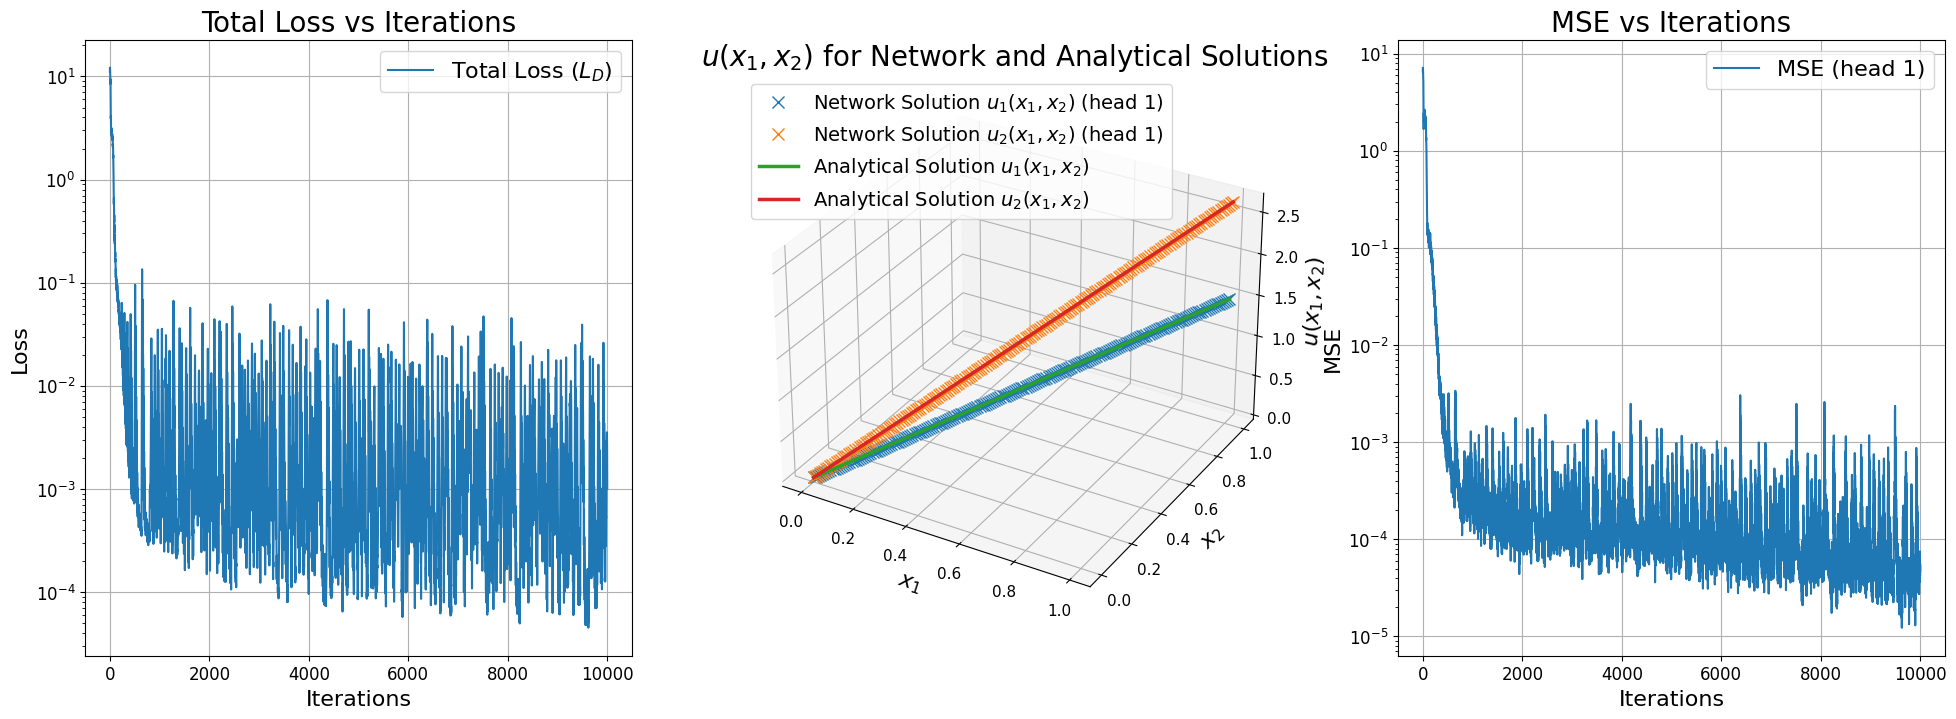

In [14]:
# plot the total loss, network vs true solution and MSE for two non-coupled equations
plot_loss_mse_and_solution(x_range=evaluation_x_range, true_functs=true_funct, iterations=iterations, 
                           trained_model=trained_model, v_list=v_list, A_list=A_list, 
                           force=force, G_list=G_list, train_losses=loss_hist['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D$)', mses=MSE_hist, 
                           head_to_track='head 1')

### Step 4a: Recover Weights for a Set of Training Parameters

Time to compute H and dH_dt:  0.587 seconds
M condition number:  tensor(7.1928e+10, device='cuda:0', grad_fn=<SqueezeBackward1>)


<ipython-input-10-341e25a420d9>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_zticklabels(ax0.get_zticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=14)


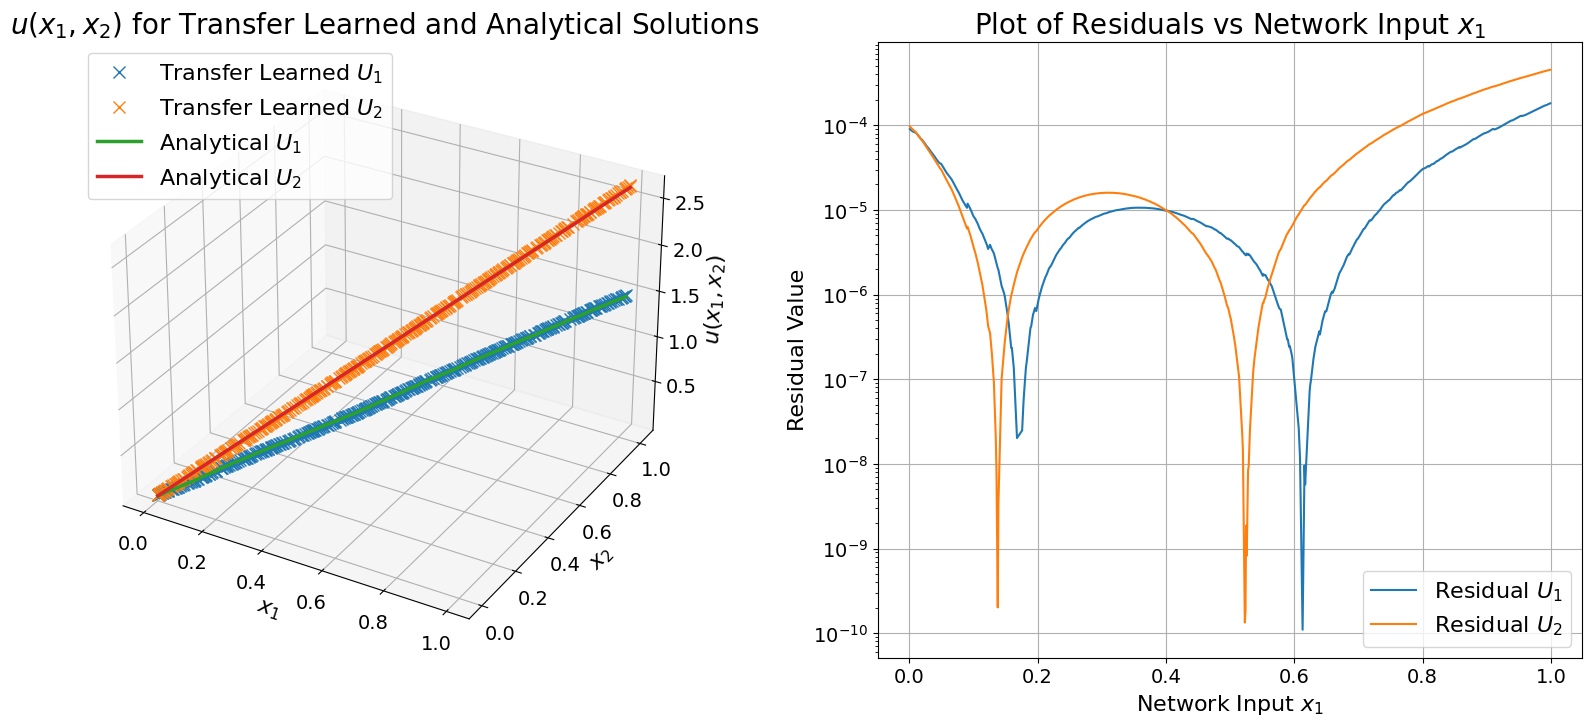

In [15]:
# pick a G, A, and boundary condition that has been trained on (recovery - easy case)
G = G_list[0]
v = v_list[0]
A = A_list[0]

# compute H, S, and H_0
H, S, H_0, x, x_0 = compute_H_and_S(training_x_range[0], training_x_range[1], G, trained_model, num_equations, hid_lay)

# compute W_out and plot the transfer learned solution
M_inv, W_out, force_terms = analytically_compute_weights(H, H_0, S, x, x_0, v, A, force)
plot_transfer_learned_and_analytical_3D(H, W_out, x, v, A, G, force, num_equations, true_funct)

### Step 4b: Perform One-Shot Transfer Learning - New Initial Condition

<ipython-input-10-341e25a420d9>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_zticklabels(ax0.get_zticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=14)


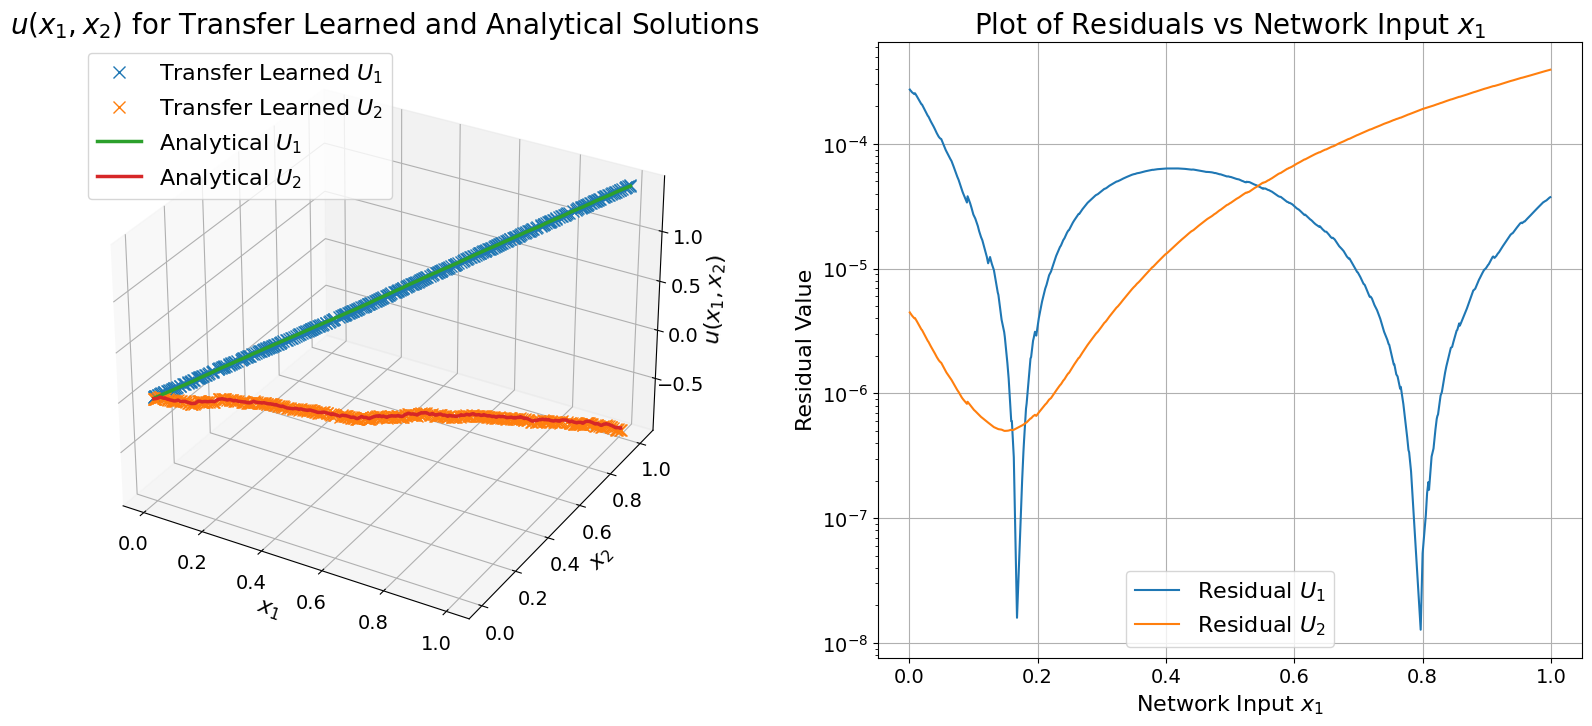

In [16]:
# choose new boundary condition that has not been trained on (harder case)
v_transfer = lambda x: torch.cat((2.0 * x[:, 0:1], -1.1 * x[:, 0:1]), dim=1)

# evaluate the x_0 on the new boundary condition
v_eval_transfer = v_transfer(x_0).reshape(-1, H.shape[1], 1)

# compute W_out and plot the transfer learned solution
W_out_transfer = torch.matmul(M_inv, force_terms + torch.matmul(H_0.mT, v_eval_transfer).mean(axis=0))
plot_transfer_learned_and_analytical_3D(H, W_out_transfer, x, v_transfer, A, G, force, num_equations, true_funct)

### Step 4c: Perform One-Shot Transfer Learning - New Equation Coefficients

Time to compute H and dH_dt:  0.492 seconds
M condition number:  tensor(3.6735e+12, device='cuda:0', grad_fn=<SqueezeBackward1>)


<ipython-input-10-341e25a420d9>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_zticklabels(ax0.get_zticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=14)


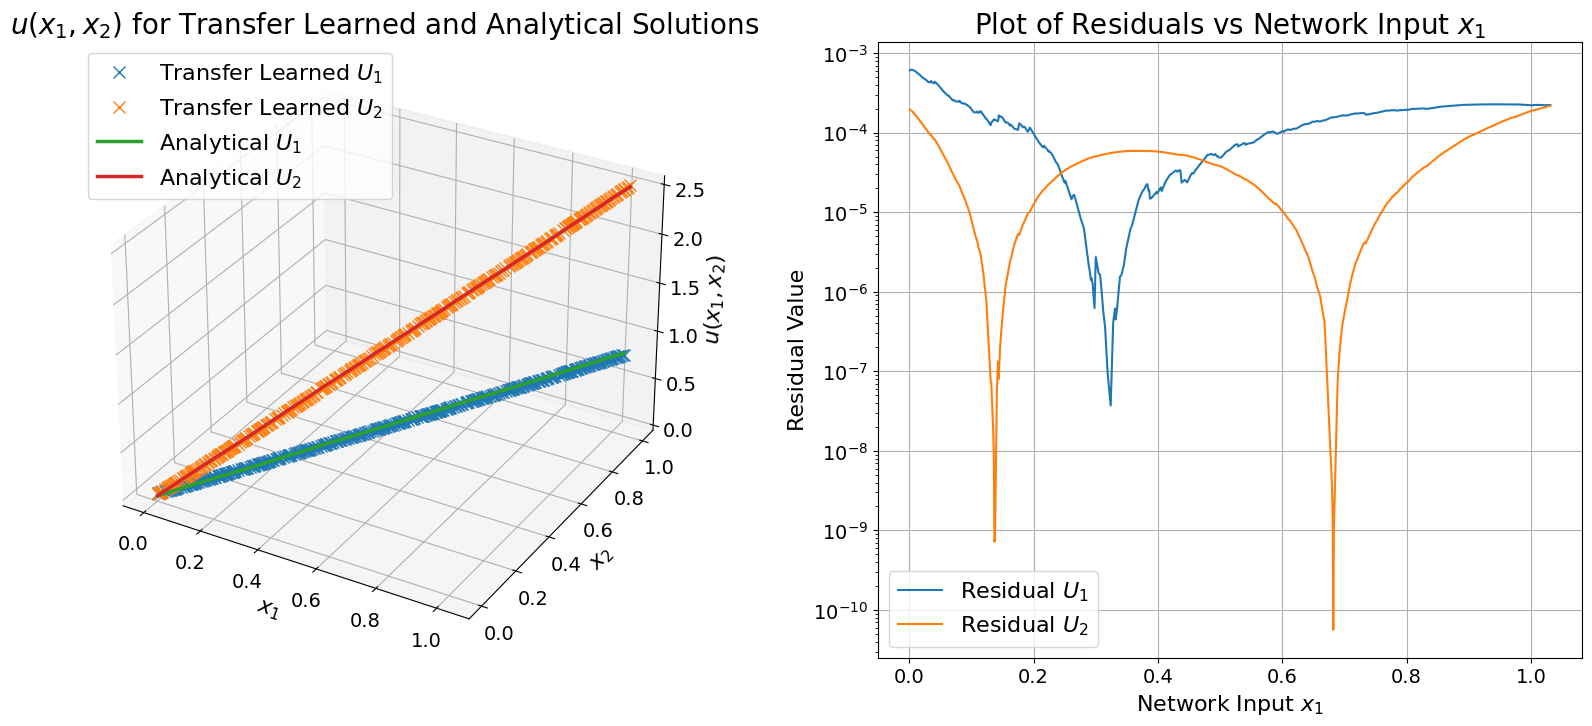

In [17]:
# choose a new A and G to transfer learn on
transfer_A = torch.tensor([[0., 0.], [0., 0.]], device=dev)
transfer_G = torch.tensor([[3.2, 5.12], [1.4, 7.3]], device=dev) 

# compute H, S, and H_0 (need a new S since G changed)
H_new, S_new, H_0_new, x_new, x_0_new = compute_H_and_S(training_x_range[0], training_x_range[1], transfer_G, trained_model, num_equations, hid_lay)

# compute W_out and plot the transfer learned solution
M_inv_new, W_out_new, force_terms_new = analytically_compute_weights(H_new, H_0_new, S_new, x_new, x_0_new, v, transfer_A, force)
plot_transfer_learned_and_analytical_3D(H_new, W_out_new, x_new, v, transfer_A, transfer_G, force, num_equations, true_funct)

### Step 4d: Perform One-Shot Transfer Learning - New Initial Condition and Equation Coefficients

Time to compute H and dH_dt:  0.230 seconds
M condition number:  tensor(5.5738e+10, device='cuda:0', grad_fn=<SqueezeBackward1>)


<ipython-input-10-341e25a420d9>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_zticklabels(ax0.get_zticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=14)
<ipython-input-10-341e25a420d9>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=14)


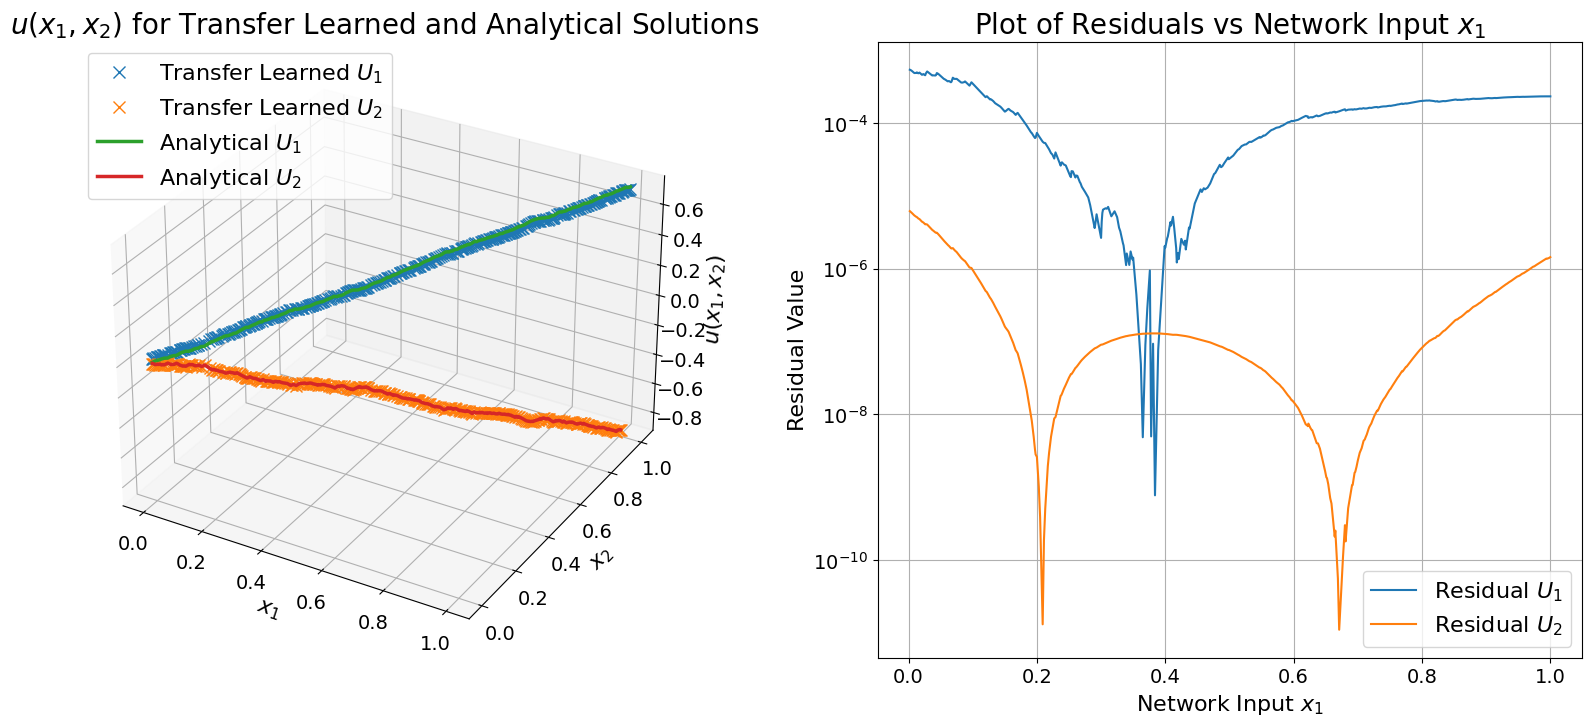

In [19]:
# choose a new A and G to transfer learn on
transfer_A_new = torch.tensor([[0., 0.], [0., 0.]], device=dev)
transfer_G_new = torch.tensor([[3.2, 5.12], [1.4, 7.3]], device=dev) 
v_transfer_new = lambda x: torch.cat((2.0 * x[:, 0:1], -1.1 * x[:, 0:1]), dim=1)

# compute H, S, and H_0 (need a new S since G changed)
H_new, S_new, H_0_new, x_new, x_0_new = compute_H_and_S(training_x_range[0], training_x_range[1], transfer_G_new, trained_model, num_equations, hid_lay)

# compute W_out and plot the transfer learned solution
M_inv_new, W_out_new, force_terms_new = analytically_compute_weights(H_new, H_0_new, S_new, x_new, x_0_new, v_transfer_new, transfer_A, force)
plot_transfer_learned_and_analytical_3D(H_new, W_out_new, x_new, v_transfer_new, transfer_A, transfer_G, force, num_equations, true_funct)

# Notes / Needed Improvements

### NOTE 1: Inside "loss" and "compute_H_and_S" functions, there is a boundary condition dependency - I can't see a way to dynamically allow the user to enter this
### NOTE 2: Code needs 2 sections generalized in order to handle more than two independent variables - I think I see a potential solution here, but am not sure if it is the best